In [42]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib.animation import FuncAnimation, PillowWriter
import plotly.graph_objs as go
from functools import reduce
import teneto


from functions.EpiIndex import *
from functions.Connectivity import *

In [55]:
patient='pte_01'
raw=mne.io.read_raw_fif(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_filtered.fif', preload=True)
#Reading a npy file 
data_alpha = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_theta_aec_dense.npy')

data_alpha_norm = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_alpha_aec_distance_dense.npy')
data_beta_norm = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_beta_aec_distance_dense.npy')
data_hgamma_norm = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_high_gamma1_aec_distance_dense.npy')
data_lgamma_norm = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_low_gamma_aec_distance_dense.npy')
data_theta_norm = np.load(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_connectivity_data_theta_aec_distance_dense.npy')
# Reading the .tsv file 


# Reading the .tsv file 
xyz_loc = pd.read_csv('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/xyz_loc.csv', sep='\t')

Opening raw data file /home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_filtered.fif...
Isotrak not found
    Range : 4758528 ... 4789248 =   9294.000 ...  9354.000 secs
Ready.
Reading 0 ... 30720  =      0.000 ...    60.000 secs...


/tmp/ipykernel_4921/449055834.py:2: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient}/{patient}_filtered.fif', preload=True)


In [56]:
from teneto import TemporalNetwork
data=data_lgamma_norm
#Preparing data node,node,time
data=data.transpose(1,2,0)
tnet_bu= TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))

tnet_bu.binarize(threshold_type='percent',threshold_level=0.10)

tnet_wu=TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))



/tmp/ipykernel_4921/3304238309.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


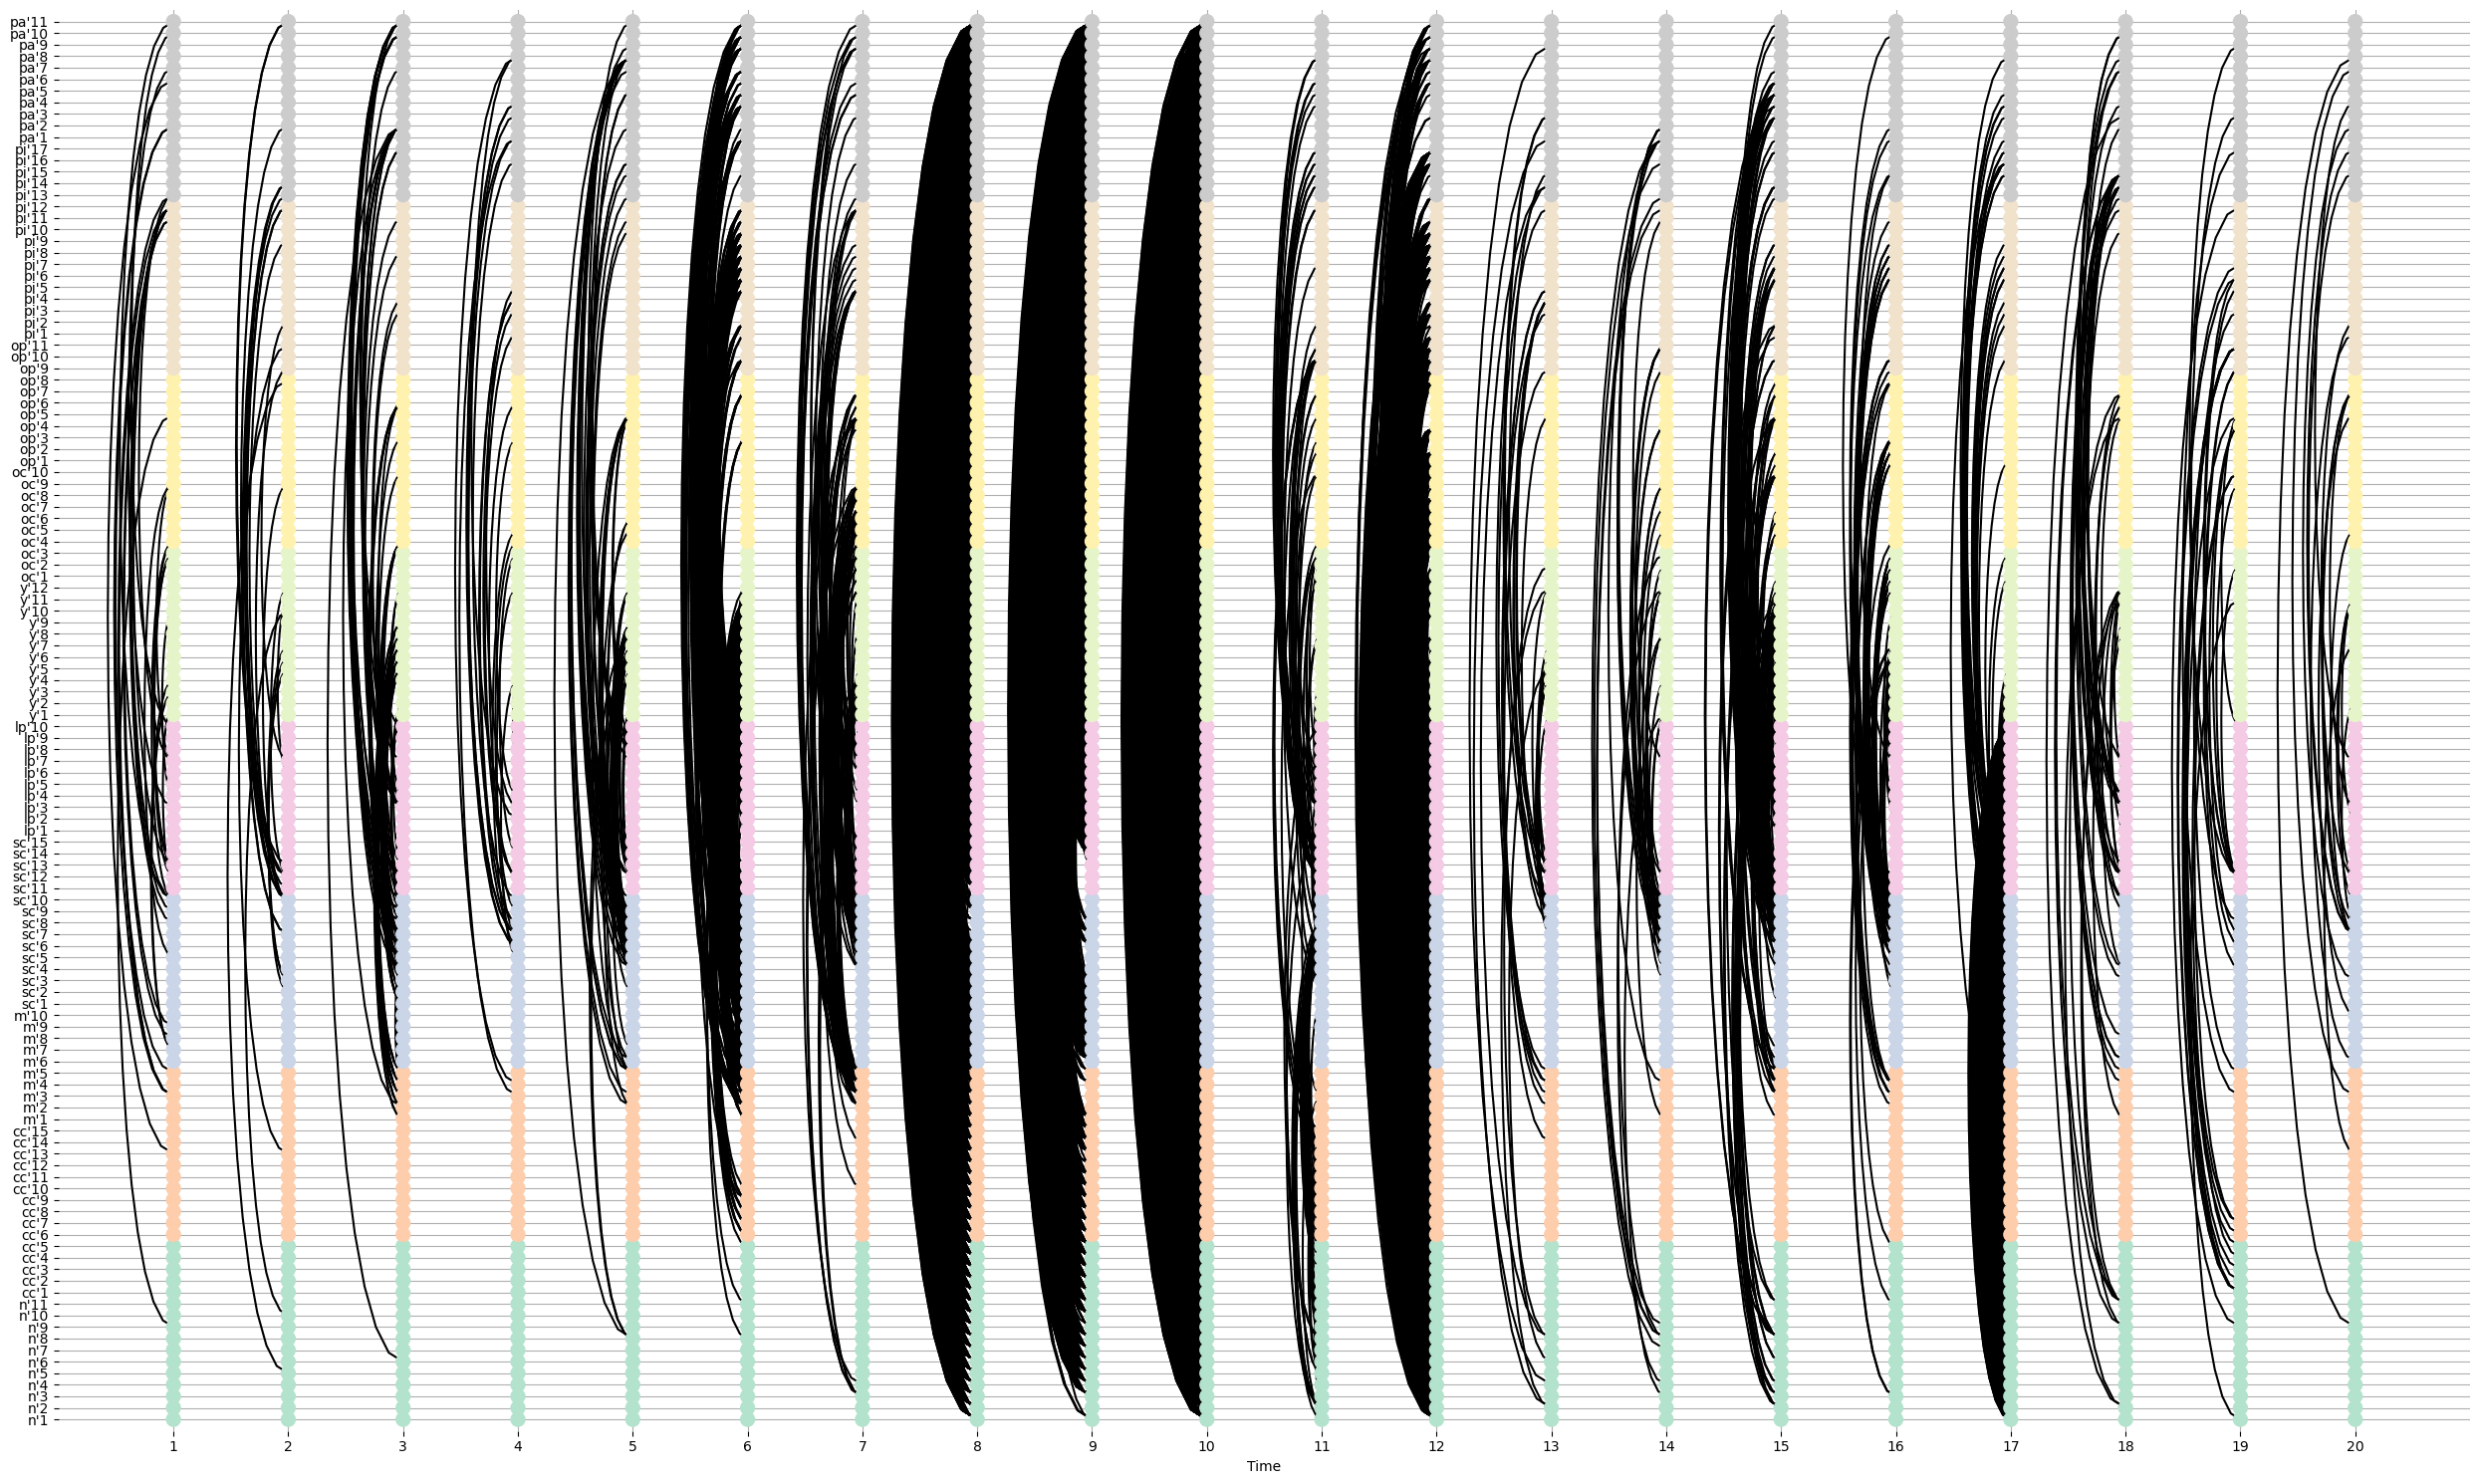

In [57]:
#Ploting the graph
from teneto import plot 

fig,ax = plt.subplots(figsize=(25,15))
ax = plot.slice_plot(tnet_bu.network, ax, plotedgeweights=False,cmap='Pastel2', nodelabels=list(xyz_loc['formatted_label'].values))
plt.tight_layout()
fig.show()

In [1]:
fig,ax = plt.subplots(figsize=(40,30))
ax = teneto.plot.graphlet_stack_plot(tnet_bu.network,ax,cmap='Reds', gridcolor='k')
fig.show()

NameError: name 'plt' is not defined

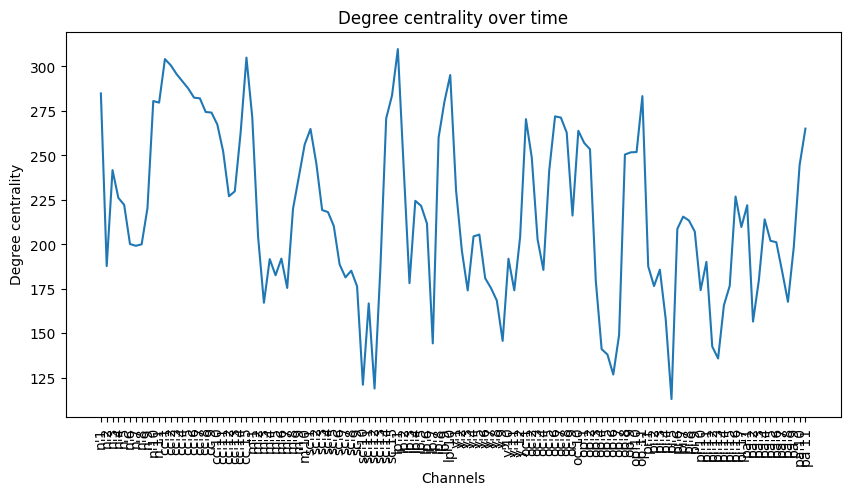

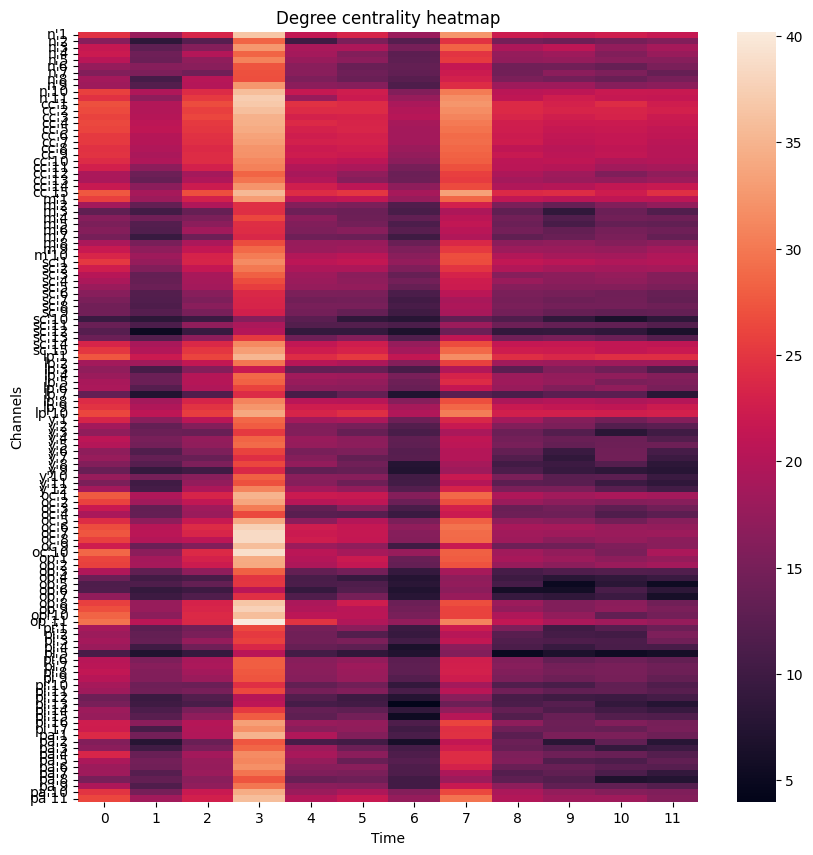

In [87]:
from teneto import networkmeasures as nwm
#Centrality measures 
degree_centrality_1=nwm.temporal_degree_centrality(tnet_wu,calc='overtime')
#Plotting the degree centrality
plt.figure(figsize=(10,5))
plt.plot(degree_centrality_1)
plt.title('Degree centrality over time')
plt.xlabel('Channels')
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values, rotation=90)
plt.ylabel('Degree centrality')
plt.show()


degree_centrality_2=nwm.temporal_degree_centrality(tnet_wu,calc='pertime')
#Plot a sns.heamap of the degree centrality
plt.figure(figsize=(10,10))
sns.heatmap(degree_centrality_2, yticklabels=xyz_loc['formatted_label'].values, xticklabels=np.arange(0, data.shape[2], 1))
plt.title('Degree centrality heatmap')
#Size of the yticks

plt.xlabel('Time')
plt.ylabel('Channels')
plt.show()



In [ ]:
#Temporal betweenness centrality
#Network has to be binary

betweenness_centrality_1=nwm.temporal_betweenness_centrality(tnet_bu,calc='overtime')
#Plotting the betweenness centrality


In [ ]:
#Temporal closeness centrality
temporal_closeness_centrality_1=nwm.temporal_closeness_centrality(tnet_bu)

In [ ]:
#Topological overal

In [ ]:
#Bursty coeff
burstiness=nwm.bursty_coeff(tnet_bu,calc='edge')

### Comumnity detection 

In [8]:
#Lovain clustering
communities=teneto.communitydetection.temporal_louvain(tnet_bu, resolution=1.5,njobs=4,consensus_threshold=0.5)

0
          i     j  weight
0       732   733       1
1       854   855       1
2       976   977       1
3      1098  1099       1
4      1220  1221       1
...     ...   ...     ...
22685  1337  1459       0
22686  1338  1460       0
22687  1339  1461       0
22688  1340  1462       0
22689  1341  1463       0

[22690 rows x 3 columns]
1


/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['i'] = self.network['i'].astype(int)
/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['j'] = self.network['j'].astype(int)


          i     j  weight
0       732   733       1
1       854   855       1
2       976   977       1
3      1098  1099       1
4      1220  1221       1
...     ...   ...     ...
22727  1337  1459       0
22728  1338  1460       0
22729  1339  1461       0
22730  1340  1462       0
22731  1341  1463       0

[22732 rows x 3 columns]
2


/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['i'] = self.network['i'].astype(int)
/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['j'] = self.network['j'].astype(int)
/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:242: SettingWithCopyWarning: 
A value is

          i     j  weight
0       732   733       1
1       854   855       1
2       976   977       1
3      1098  1099       1
4      1220  1221       1
...     ...   ...     ...
22727  1337  1459       0
22728  1338  1460       0
22729  1339  1461       0
22730  1340  1462       0
22731  1341  1463       0

[22732 rows x 3 columns]


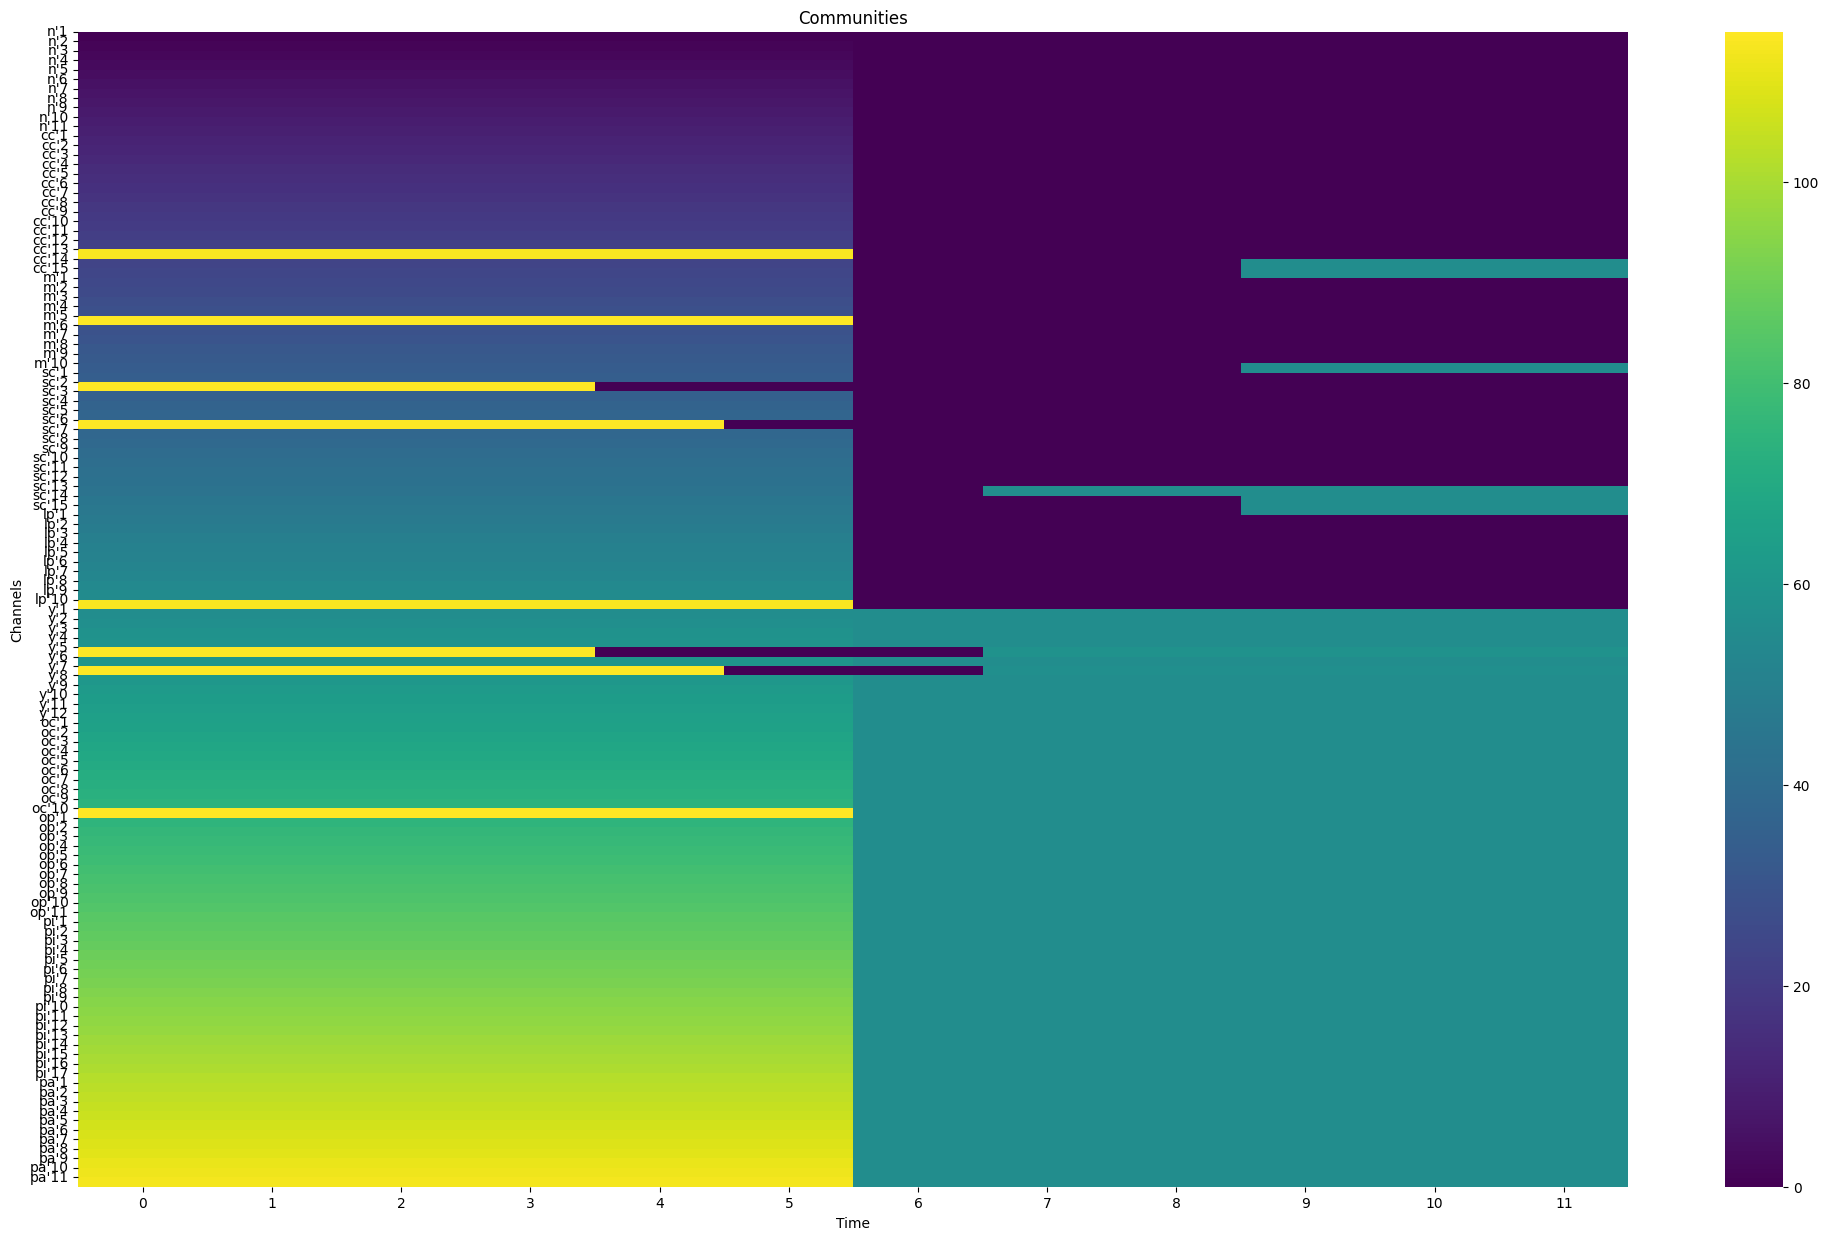

In [9]:
#plotting the communities
fig,ax = plt.subplots(figsize=(25,15))
sns.heatmap(communities,cmap='viridis',ax=ax)
plt.title('Communities')
plt.xlabel('Time')

plt.ylabel('Channels')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()

#### SubCommunity metrics

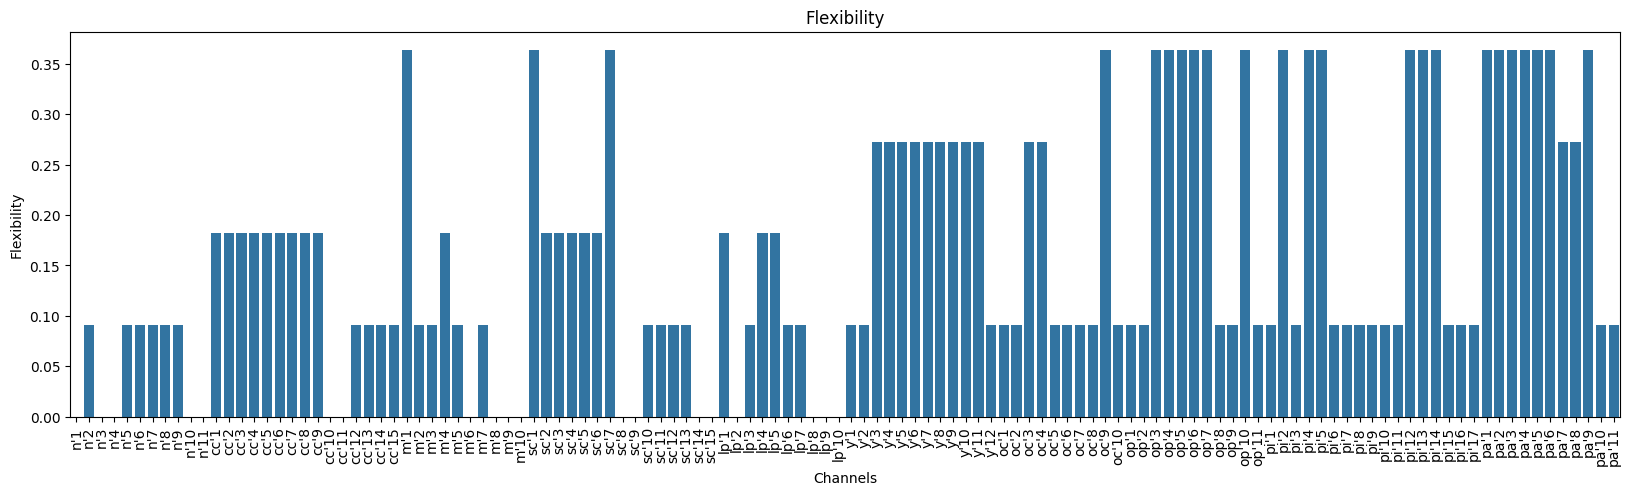

In [10]:
from teneto import communitymeasures
#Community measures
flexibility_m=communitymeasures.flexibility(communities)
plt.figure(figsize=(20,5))
#Plotting the flexibility
sns.barplot(x=xyz_loc['formatted_label'].values, y=flexibility_m)
plt.title('Flexibility')
plt.xlabel('Channels')
plt.ylabel('Flexibility')
plt.xticks(rotation=90)
plt.show()

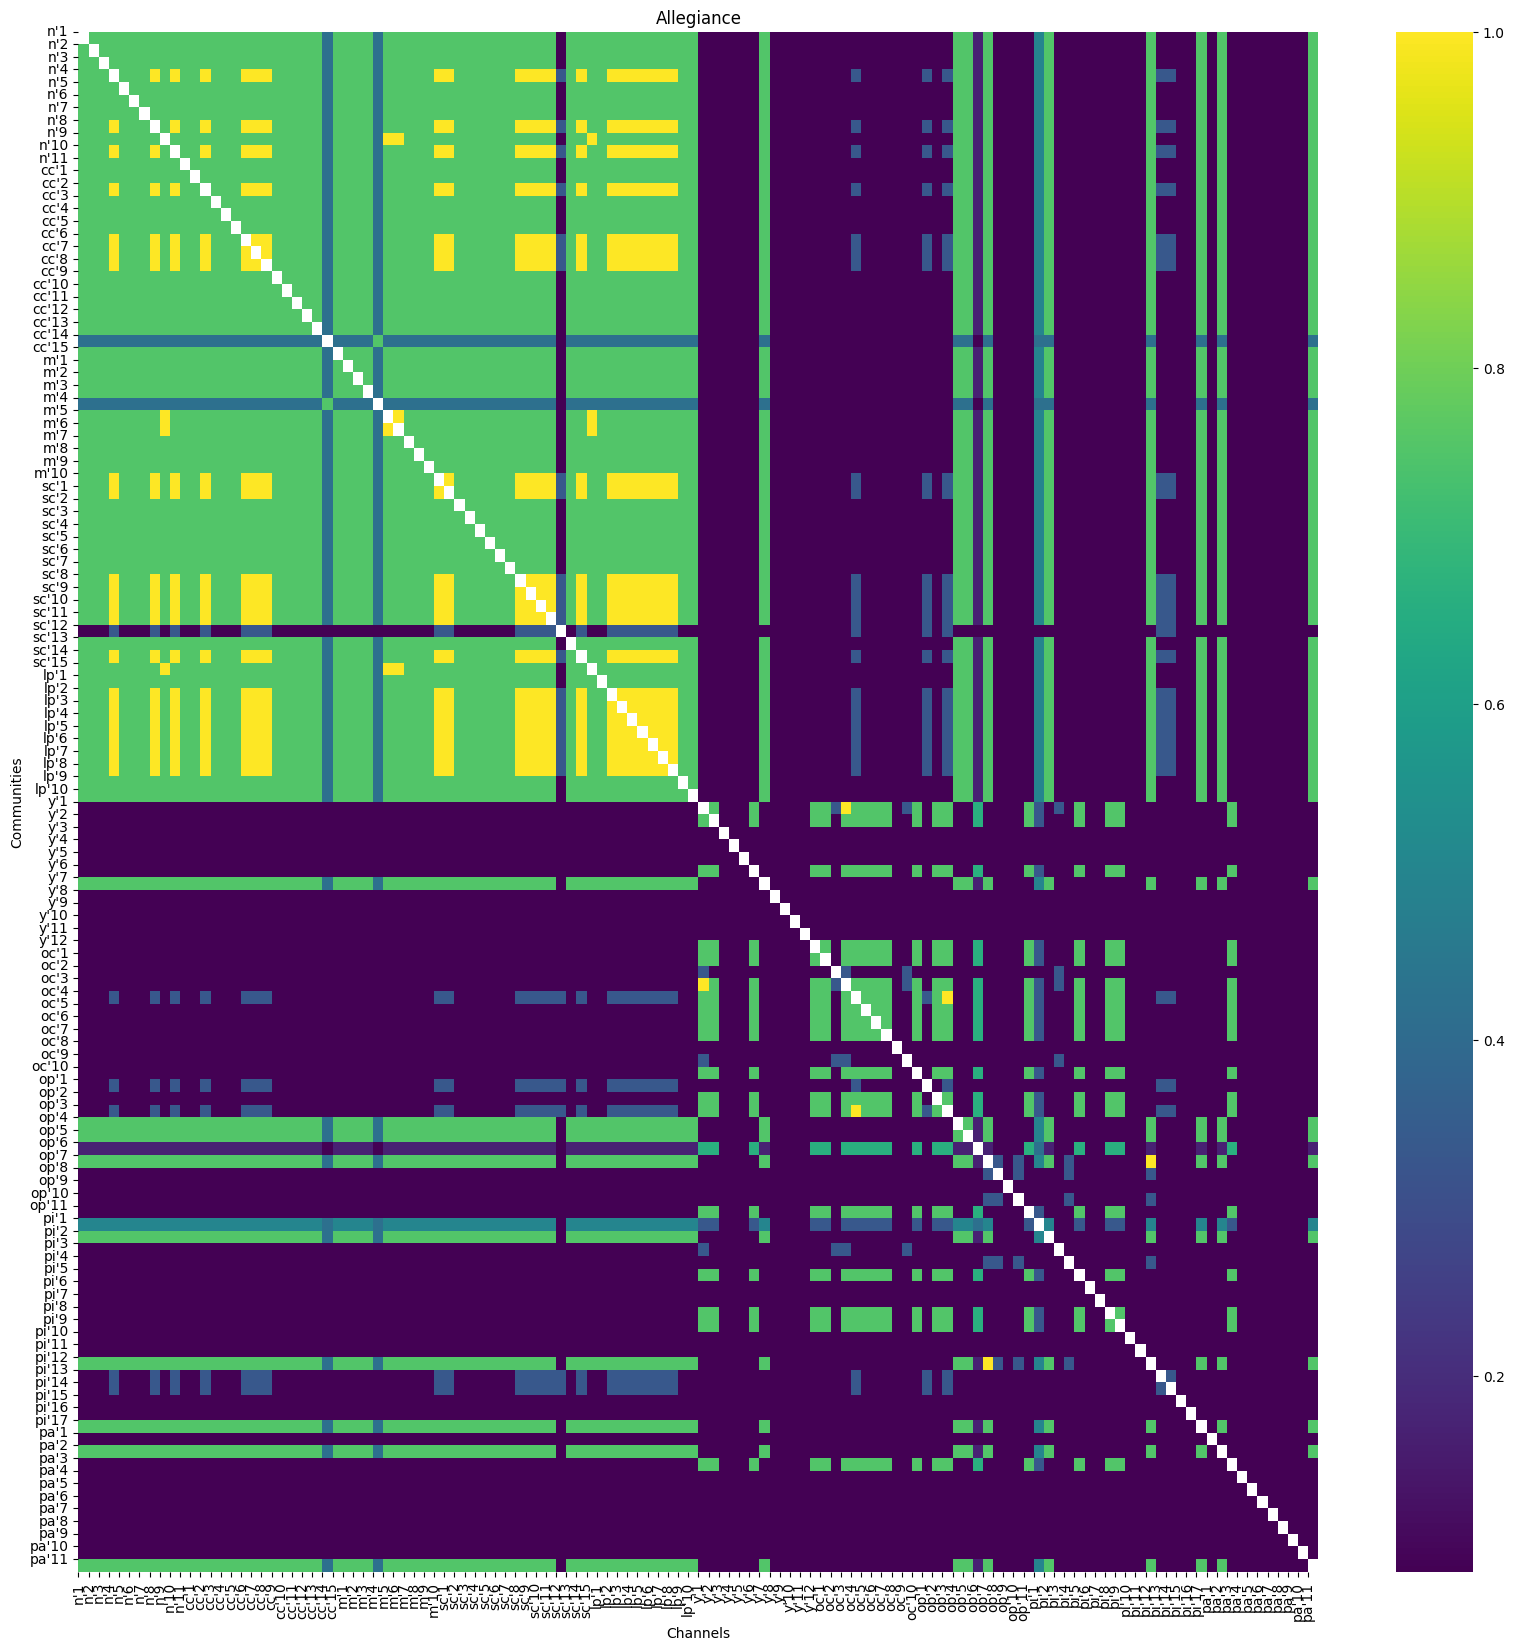

In [143]:
allegiance_m=communitymeasures.allegiance(communities)
plt.figure(figsize=(20,20))
sns.heatmap(allegiance_m,cmap='viridis')
plt.title('Allegiance')
plt.xlabel('Channels')
plt.ylabel('Communities')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()

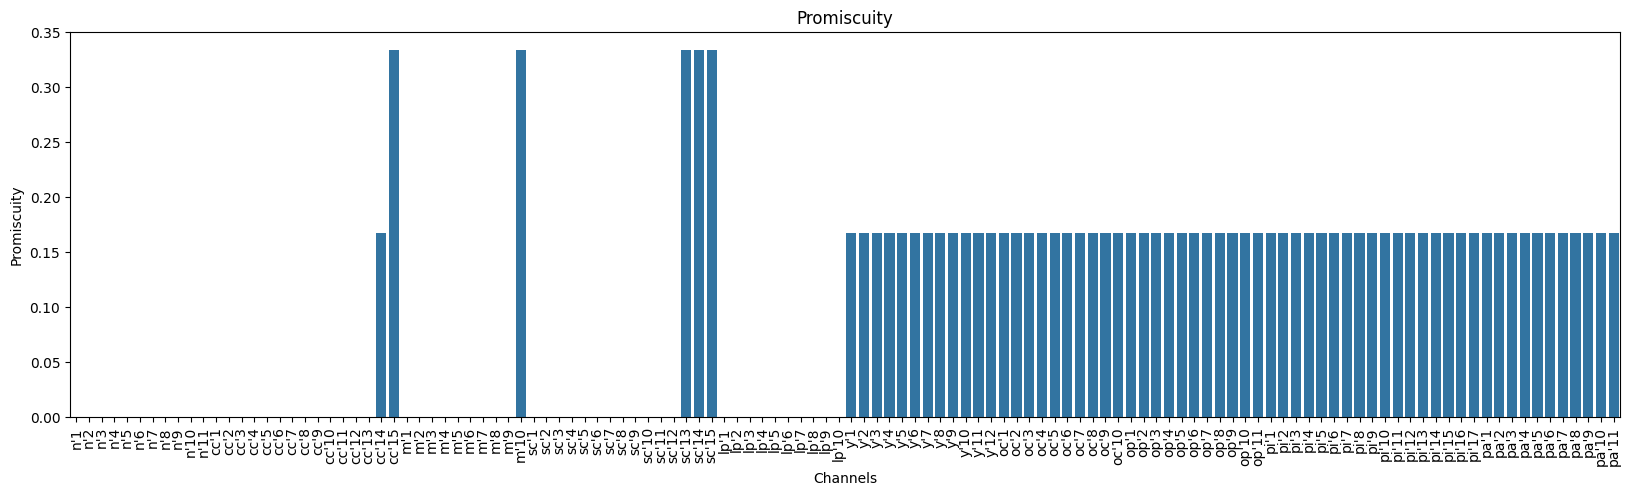

In [84]:
promiscuity_m=communitymeasures.promiscuity(communities)
plt.figure(figsize=(20,5))
sns.barplot(x=xyz_loc['formatted_label'].values, y=promiscuity_m)
plt.title('Promiscuity')
plt.xlabel('Channels')
plt.ylabel('Promiscuity')
plt.xticks(rotation=90)
plt.show()

In [13]:
persistence_mg=communitymeasures.persistence(communities,calc='global')
persistence_mt=communitymeasures.persistence(communities,calc='time')
persistence_mn=communitymeasures.persistence(communities,calc='node')

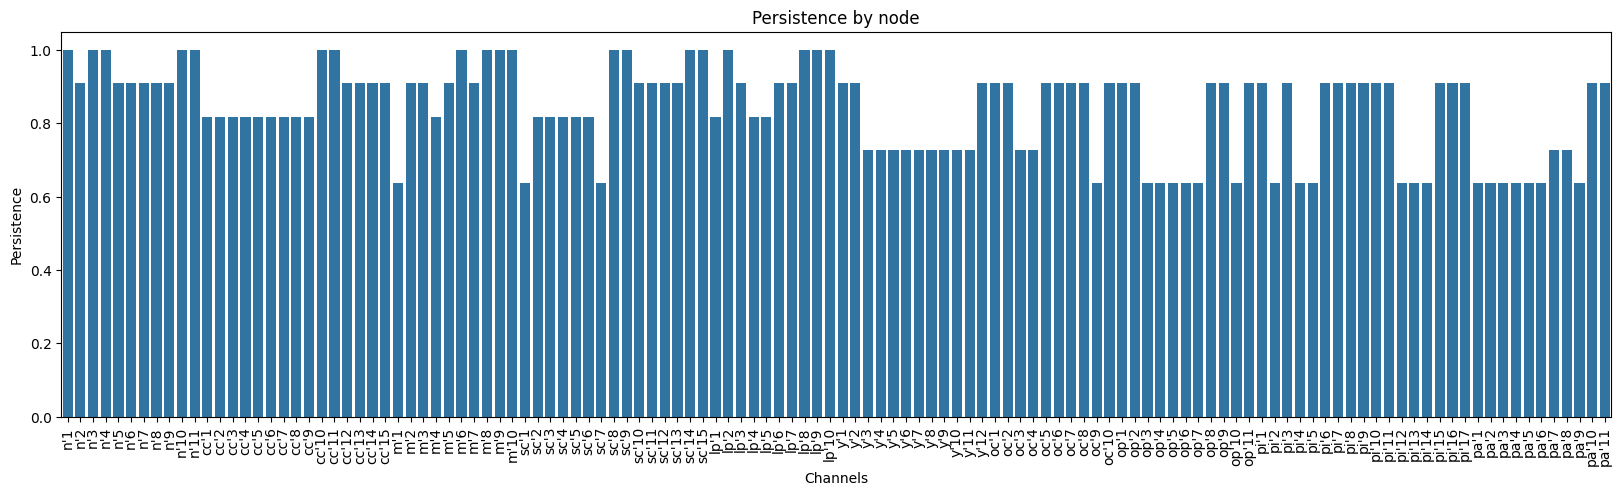

In [14]:
plt.figure(figsize=(20,5))
sns.barplot(x=xyz_loc['formatted_label'].values, y=persistence_mn)
plt.title('Persistence by node')
plt.xlabel('Channels')
plt.ylabel('Persistence')
plt.xticks(rotation=90)
plt.show()

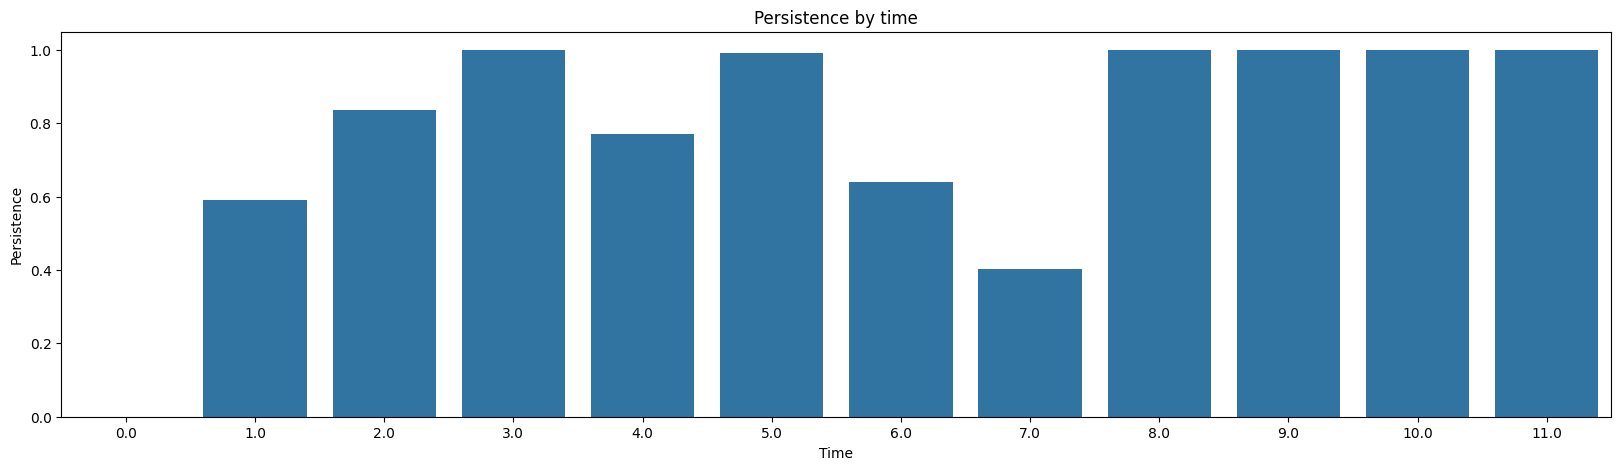

In [15]:
plt.figure(figsize=(20,5))
sns.barplot(x=np.linspace(0, 11, data.shape[2]), y=persistence_mt)   
plt.title('Persistence by time')
plt.xlabel('Time')
plt.ylabel('Persistence')
plt.show()


In [19]:
communities.shape

(122, 12)

In [28]:
#Transform communities array into a integer instead of float
communities_int=communities.astype(int)

In [31]:
communities_int

array([[19, 19, 19, ..., 19, 19, 19],
       [ 1,  1,  1, ..., 19, 19, 19],
       [19, 19, 19, ..., 19, 19, 19],
       ...,
       [19,  0, 22, ...,  0,  0,  0],
       [19, 19, 19, ...,  0,  0,  0],
       [19, 19, 19, ...,  0,  0,  0]])

In [97]:
#SID
sid=nwm.sid(tnet_wu,communities=communities_int,calc='community_pairs')

<Axes: >

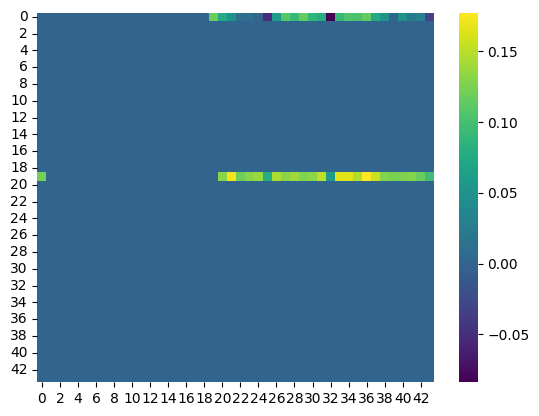

In [98]:
sns.heatmap(sid[:,:,7],cmap='viridis')